## Delivery Duration Prediction

When a consumer places an order on DoorDash, we show the expected time of delivery. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. In this exercise, you will build a model to predict the estimated time taken for a delivery.

Concretely, for a given delivery you must predict the total delivery duration seconds , i.e., the time taken from:

__Start:__ the time consumer submits the order `(created_at)` to

__End:__ when the order will be delivered to the consumer `(actual_delivery_time)`

#### My Approach

The dataset comes with two other predicted values: `estimated_order_place_duration` and `estimated_store_to_consumer_driving_duration`. The missing piece is the amount of time the order spends in the store. In addition to generic feature engineering, I will be creating separate order 'prep_time' statistics tables/dataframes to simulate gold fact tables in a database or features from a feature store (i.e. Feather, Feast) that would in turn live in a data lake.

This is a fairly popular exercise so it is possible to derive performance objectives. My goal is to produce a feature set and model that has a test RMSE of less than 900 seconds against a holdout size of 0.2, a cross-validated RMSE of less than 950 and a test MAE of less than 600 seconds. My stretch goal is a cross-validated RMSE less than 900. For reference, the best models publically available produce a test RMSE around 980 - 1000 seconds with a holdout size of 0.2. 

In [20]:
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import datetime as dt
from datetime import timedelta

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,roc_auc_score,log_loss
from scipy.stats import linregress
from scipy import stats

from flaml import AutoML
from flaml.automl.model import XGBoostEstimator

In [2]:
np.random.seed(42)

In [3]:
## update types
## create target variable
def addFeatures_durations(historical_data:pd.DataFrame) -> pd.DataFrame:
    try:
        historical_data['created_at'] = pd.to_datetime(historical_data['created_at'])
        historical_data['actual_delivery_time'] = pd.to_datetime(historical_data['actual_delivery_time'])
        ## calculate delivery duration
        historical_data['actual_total_delivery_duration'] = (historical_data['actual_delivery_time'] - historical_data['created_at']).dt.total_seconds()
        ## estimated time spent outside the store/not on order preparation
        historical_data['est_time_non-prep'] = historical_data['estimated_order_place_duration'] + historical_data['estimated_store_to_consumer_driving_duration']
    except Exception as ex:
        raise ex
    return historical_data

In [4]:
def createBaseline(historical_data:pd.DataFrame) -> pd.DataFrame:   #this function would be done in practice by SQL or Spark
    historical_data = addFeatures_durations(historical_data=historical_data)
    try:
        baseline_data = historical_data[['store_id','actual_total_delivery_duration']]
        baseline_data = baseline_data.dropna()
        baseline_data = pd.merge(
            left=baseline_data,
            right=baseline_data.groupby('store_id').actual_total_delivery_duration.aggregate([np.mean,np.std]),
            how='inner',
            on='store_id'
        )
        baseline_data['z-score'] = (baseline_data['actual_total_delivery_duration'] - baseline_data['mean']) / baseline_data['std']
        baseline_data = baseline_data.loc[(baseline_data['z-score'] <=3) & (baseline_data['z-score'] >= -3)]
        baseline_avgs = baseline_data.groupby('store_id').actual_total_delivery_duration.aggregate([np.mean])
        baseline_data = pd.merge(
            left=historical_data[['store_id','actual_total_delivery_duration']].dropna(),
            right=baseline_avgs,
            on='store_id'
        )
        baseline_MAE = mean_absolute_error(y_true=baseline_data['actual_total_delivery_duration'],y_pred=baseline_data['mean'])
        baseline_RMSE = mean_squared_error(y_true=baseline_data['actual_total_delivery_duration'],y_pred=baseline_data['mean'],squared=False)
    except Exception as ex:
        raise ex
    return {'baseline_MAE:':baseline_MAE,'baseline_RMSE:':baseline_RMSE}

In [5]:
## TODO #4 create estimated prep time features that are anchored to stores and/or categories -- DONE
# the est_time_prep feature depends on the actual delivery datetime, which can't be provided to a model
# BUT a set of values derived from historical data can be given to a model on demand

def addFeatures_store_prep_stats(historical_data:pd.DataFrame) -> pd.DataFrame:   #this function would be done in practice by SQL or Spark
## returns a separate dataframe with the min, max, median and mean and standard deviation of the est_prep_time_per_item for each store_id
    try:
        historical_data = addFeatures_durations(historical_data=historical_data)
        ## calculate the amount of time (in seconds) the order spends in the store, then divide by the total number of items in the order
        historical_data['est_time_prep_per_item'] = (historical_data['actual_total_delivery_duration'] - historical_data['est_time_non-prep']) / historical_data['total_items']
        historical_data = historical_data[historical_data['est_time_prep_per_item'] > 0]
        store_prep_stats_df = historical_data[['store_id','est_time_prep_per_item']].groupby('store_id').est_time_prep_per_item.aggregate([np.mean,np.std])
        ## calculate z-score
        store_prep_facts_df = pd.merge(
            left=store_prep_stats_df.reset_index(),
            right=historical_data[['store_id','est_time_prep_per_item']],
            how='inner',
            on='store_id'
        )
        store_prep_facts_df['z_score'] = (store_prep_facts_df['est_time_prep_per_item'] - store_prep_facts_df['mean']) / store_prep_facts_df['std']
        ## drop outliers
        store_prep_stats_df = store_prep_facts_df.loc[(store_prep_facts_df['z_score'] <=3) & (store_prep_facts_df['z_score'] >= -3)]
        store_prep_stats_df = store_prep_stats_df.drop(columns=['mean','std'])
        store_prep_stats_df = store_prep_stats_df.groupby('store_id').est_time_prep_per_item.aggregate(['min','max','median',np.mean,np.std])
        store_prep_stats_df = store_prep_stats_df.add_prefix('store_est_time_prep_per_item_')
    except Exception as ex:
        raise ex
    return store_prep_stats_df

def addFeatures_category_prep_stats(historical_data:pd.DataFrame) -> pd.DataFrame:   #this function would be done in practice by SQL or Spark
## returns a separate dataframe with the min,max, median, mean and standard deviation for each category
    try:
        historical_data = addFeatures_durations(historical_data=historical_data)
        ## calculate the amount of time (in seconds) the order spends in the store, then divide by the total number of items in the order
        historical_data['est_time_prep_per_item'] = (historical_data['actual_total_delivery_duration'] - historical_data['est_time_non-prep']) / historical_data['total_items']
        historical_data = historical_data[historical_data['est_time_prep_per_item'] > 0]
        category_prep_stats_df = historical_data[['clean_store_primary_category','est_time_prep_per_item']].groupby('clean_store_primary_category').est_time_prep_per_item.aggregate([np.mean,np.std])
        ## calculate z-score
        category_prep_facts_df = pd.merge(
            left=category_prep_stats_df.reset_index(),
            right=historical_data[['created_at','clean_store_primary_category','est_time_prep_per_item']],
            how='inner',
            on='clean_store_primary_category'
        )
        category_prep_facts_df['z_score'] = (category_prep_facts_df['est_time_prep_per_item'] - category_prep_facts_df['mean']) / category_prep_facts_df['std']
        ## drop outliers
        category_prep_stats_df = category_prep_facts_df.loc[(category_prep_facts_df['z_score'] <= 3) & (category_prep_facts_df['z_score'] >= -3)]
        category_prep_stats_df = category_prep_stats_df.drop(columns=['mean','std','created_at'])
        category_prep_stats_df = category_prep_stats_df.groupby('clean_store_primary_category').est_time_prep_per_item.aggregate(['min','max','median',np.mean,np.std])
        category_prep_stats_df = category_prep_stats_df.add_prefix('category_est_time_prep_per_item_')
    except Exception as ex:
        raise ex
    return category_prep_stats_df

In [6]:
## add time of day features

def addFeatures_time_of_day(historical_data:pd.DataFrame) -> pd.DataFrame:
    try:
        historical_data['created_hour_of_day'] = historical_data['created_at'].dt.hour
        historical_data['created_day_of_week'] = historical_data['created_at'].dt.day_of_week
    except Exception as ex:
        raise ex
    return historical_data

In [7]:
## add ratio features
def addFeatures_ratios(historical_data:pd.DataFrame) -> pd.DataFrame:
    try:
        # historical_data['total_onshift_dashers'].mask(historical_data['total_busy_dashers'] > historical_data['total_onshift_dashers'],historical_data['total_busy_dashers'],inplace=True)
        historical_data['available_dashers'] = historical_data['total_onshift_dashers'] - historical_data['total_busy_dashers']
        historical_data['orders_without_dashers'] = historical_data['total_outstanding_orders'] - historical_data['total_onshift_dashers']
        historical_data['available_to_outstanding'] = historical_data['available_dashers'] / historical_data['total_outstanding_orders']
        historical_data['available_to_outstanding'].replace(to_replace=[np.inf,-np.inf],value=historical_data['available_dashers'][1],inplace=True)
        historical_data['busy_to_onshift'] = historical_data['total_onshift_dashers'] / historical_data['total_busy_dashers']
        historical_data['busy_to_onshift'].replace(to_replace=[np.inf,-np.inf],value=historical_data['total_onshift_dashers'][1],inplace=True)
        historical_data['busy_to_outstanding'] = historical_data['total_busy_dashers'] / historical_data['total_outstanding_orders']
        historical_data['busy_to_outstanding'].replace(to_replace=[np.inf,-np.inf,np.nan],value=0,inplace=True)
        historical_data['onshift_to_outstanding'] = historical_data['total_onshift_dashers'] / historical_data['total_outstanding_orders']
        historical_data['onshift_to_outstanding'].replace([np.inf,-np.inf],0,inplace=True)
    except Exception as ex:
        raise ex
    return historical_data

In [8]:
def addFeatures_relative_abundances(historical_data:pd.DataFrame,train_df=pd.DataFrame) -> pd.DataFrame:
    ## outstanding order and Dasher relative abundances per market
    # Independent sample tests conducted below indicate that the average order by hour populations differ between markets, so we also group by market in addition to hour
    assert 'market_id','created_hour_of_day' in train_df.columns; 'Matching market_id and/or created_hour_of_day columns not found in train_df'
    try:
        market_hour_abd = historical_data.groupby(['market_id','created_hour_of_day'])['total_outstanding_orders','total_onshift_dashers','total_busy_dashers'].aggregate(np.mean).add_prefix('market_hour_mean_')
        hour_abd = historical_data.groupby(['created_hour_of_day'])['total_outstanding_orders','total_onshift_dashers','total_busy_dashers'].aggregate(np.mean).add_prefix('hour_mean_')

        train_df = pd.merge(left=train_df,right=market_hour_abd,on=['market_id','created_hour_of_day'])
        train_df = pd.merge(left=train_df,right=hour_abd,on=['created_hour_of_day'])
        # market hour abundances
        train_df['market_hour_onshift_outs_avg'] = train_df['market_hour_mean_total_onshift_dashers'] / train_df['market_hour_mean_total_outstanding_orders']
        train_df['market_hour_onshift_to_outstanding_abd'] = train_df['onshift_to_outstanding'] / train_df['market_hour_onshift_outs_avg']
        train_df['market_hour_busy_outs_avg'] = train_df['market_hour_mean_total_busy_dashers'] / train_df['market_hour_mean_total_outstanding_orders']
        train_df['market_hour_busy_to_outstanding_abd'] = train_df['busy_to_outstanding'] / train_df['market_hour_busy_outs_avg']
        train_df['market_hour_outs_order_abd'] = train_df['total_outstanding_orders'] / train_df['market_hour_mean_total_outstanding_orders']
        train_df['market_hour_busy_dasher_abd'] = train_df['total_busy_dashers'] / train_df['market_hour_mean_total_busy_dashers']
        # hour abundances
        train_df['hour_onshift_outs_avg'] = train_df['hour_mean_total_onshift_dashers'] / train_df['hour_mean_total_outstanding_orders']
        train_df['hour_onshift_to_outstanding_abd'] = train_df['onshift_to_outstanding'] / train_df['hour_onshift_outs_avg']
        train_df['hour_busy_outs_avg'] = train_df['hour_mean_total_busy_dashers'] / train_df['hour_mean_total_outstanding_orders']
        train_df['hour_busy_to_outstanding_abd'] = train_df['busy_to_outstanding'] / train_df['hour_busy_outs_avg']
        train_df['hour_outs_order_abd'] = train_df['total_outstanding_orders'] / train_df['hour_mean_total_outstanding_orders']
        train_df['hour_busy_dasher_abd'] = train_df['total_busy_dashers'] / train_df['hour_mean_total_busy_dashers']
    except Exception as ex:
        raise ex
    return train_df

In [9]:
## add dummies for categories
def addFeatures_dummies(historical_data:pd.DataFrame,dummy_column:str) -> pd.DataFrame:
    try:
        dumm = pd.get_dummies(historical_data[dummy_column],prefix=str(dummy_column + '_'),dtype=float)
        # concat dummies
        historical_data = pd.concat([historical_data,dumm],axis=1)
        historical_data = historical_data.drop(columns=[dummy_column])
    except Exception as ex:
        raise ex
    return historical_data

In [10]:
## remove confounding outliers
def cleanFeatures_remove_outliers(historical_data:pd.DataFrame) -> pd.DataFrame:
    try:
        historical_data = historical_data.loc[historical_data['actual_total_delivery_duration'] > historical_data['est_time_non-prep']]
        historical_data = historical_data[historical_data['actual_total_delivery_duration'] < 86400] # the equivalent of an entire day
    except Exception as ex:
        raise ex
    return historical_data        

In [11]:
historical_data = pd.read_csv('historical_data.csv')


store_id_unique = historical_data["store_id"].unique().tolist()
store_id_and_category = {store_id: historical_data[historical_data.store_id == store_id].store_primary_category.mode() 
                         for store_id in store_id_unique}
def fill(store_id):
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan
# fill null values
historical_data["clean_store_primary_category"] = historical_data.store_id.apply(fill)

## build store, category prep time statistics DataFrames
store_prep_stats_df = addFeatures_store_prep_stats(historical_data=historical_data)
#category_prep_stats_df = addFeatures_category_prep_stats(historical_data=historical_data)
## build the training dataset using the functions above
train_df = addFeatures_durations(historical_data=historical_data)
train_df = addFeatures_ratios(historical_data=train_df)
train_df = addFeatures_time_of_day(historical_data=train_df)
train_df = addFeatures_relative_abundances(historical_data=train_df,train_df=train_df)
## merge store, category prep stats DataFrames with train_df
train_df = pd.merge(
    left=train_df,
    right=store_prep_stats_df.reset_index(),
    how='inner',
    on='store_id'
)
# train_df = pd.merge(
#    left=train_df,
#    right=category_prep_stats_df.reset_index(),
#    how='inner',
#    on='clean_store_primary_category'
#)
## remove confounding outliers
train_df = cleanFeatures_remove_outliers(historical_data=train_df)
## add total prep time estimations
train_df['store_est_median_total_prep_time'] = train_df['total_items'] * train_df['store_est_time_prep_per_item_median']
train_df['store_est_mean_total_prep_time'] = train_df['total_items'] * train_df['store_est_time_prep_per_item_mean']
## add dummy columns for clean_store_primary_category, market_id, order_protocol
train_df = addFeatures_dummies(historical_data=train_df,dummy_column='clean_store_primary_category')
train_df = addFeatures_dummies(historical_data=train_df,dummy_column='market_id')
train_df = addFeatures_dummies(historical_data=train_df,dummy_column='order_protocol')
train_df = addFeatures_dummies(historical_data=train_df,dummy_column='created_hour_of_day')
train_df = addFeatures_dummies(historical_data=train_df,dummy_column='created_day_of_week')
## prep time training dataframe
# prep_time_df = train_df.copy(deep=True)
# prep_time_df['est_order_total_prep_time'] = prep_time_df['actual_total_delivery_duration'] - prep_time_df['est_time_non-prep']
#prep_time_df['est_order_time_prep_per_item'] = prep_time_df['est_order_total_prep_time'] / prep_time_df['total_items']
## drop the native 'store_primary_category' column and all remaining non-feature columns, then do a headcheck
train_df.drop(columns=['store_primary_category','created_at','actual_delivery_time','store_id','est_time_prep_per_item'],inplace=True)
# prep_time_df.drop(columns=['store_primary_category','created_at','actual_delivery_time','store_id','est_time_prep_per_item','actual_total_delivery_duration'],inplace=True)
## drop NaN's
train_df.dropna(inplace=True)
train_df = train_df.astype("float32")
# prep_time_df.dropna(inplace=True)
# prep_time_df = prep_time_df.astype('float32')

train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,created_hour_of_day__21,created_hour_of_day__22,created_hour_of_day__23,created_day_of_week__0,created_day_of_week__1,created_day_of_week__2,created_day_of_week__3,created_day_of_week__4,created_day_of_week__5,created_day_of_week__6
24,5.0,2175.0,2.0,350.0,375.0,16.0,18.0,21.0,446.0,879.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25,5.0,1750.0,4.0,250.0,475.0,22.0,22.0,26.0,446.0,424.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26,4.0,1400.0,1.0,350.0,350.0,18.0,18.0,29.0,446.0,605.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
27,5.0,1650.0,2.0,250.0,350.0,29.0,27.0,28.0,446.0,604.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
28,11.0,3375.0,9.0,200.0,475.0,36.0,38.0,59.0,446.0,480.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [82]:
## Variance in average outstanding orders by hour between different markets. Different populations will generate a value less than 0.25 or greater than 4
# If the p-value for the Welch's t-test is less than 0.05, then the means of the populations are different enough to warrant splitting in feature development
print("Markets 1,2:")
print(np.var(historical_data[historical_data['market_id'] == 1].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean))/np.var(historical_data[historical_data['market_id'] == 2].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean)))
print(stats.ttest_ind(historical_data[historical_data['market_id'] == 1].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),historical_data[historical_data['market_id'] == 2].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),equal_var=False))
print("Markets 1,3:")
print(np.var(historical_data[historical_data['market_id'] == 1].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean))/np.var(historical_data[historical_data['market_id'] == 3].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean)))
print(stats.ttest_ind(historical_data[historical_data['market_id'] == 1].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),historical_data[historical_data['market_id'] == 2].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),equal_var=True))
print("Markets 1,4:")
print(np.var(historical_data[historical_data['market_id'] == 1].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean))/np.var(historical_data[historical_data['market_id'] == 4].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean)))
print(stats.ttest_ind(historical_data[historical_data['market_id'] == 1].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),historical_data[historical_data['market_id'] == 2].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),equal_var=False))
print("Markets 2,3:")
print(np.var(historical_data[historical_data['market_id'] == 2].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean))/np.var(historical_data[historical_data['market_id'] == 3].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean)))
print(stats.ttest_ind(historical_data[historical_data['market_id'] == 1].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),historical_data[historical_data['market_id'] == 2].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),equal_var=False))
print("Markets 2,4:")
print(np.var(historical_data[historical_data['market_id'] == 2].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean))/np.var(historical_data[historical_data['market_id'] == 4].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean)))
print(stats.ttest_ind(historical_data[historical_data['market_id'] == 1].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),historical_data[historical_data['market_id'] == 2].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),equal_var=True))
print("Markets 3,4:")
print(np.var(historical_data[historical_data['market_id'] == 3].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean))/np.var(historical_data[historical_data['market_id'] == 4].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean)))
print(stats.ttest_ind(historical_data[historical_data['market_id'] == 1].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),historical_data[historical_data['market_id'] == 2].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),equal_var=False))

Markets 1,2:
0.14396329619338816
Ttest_indResult(statistic=-3.020034348335915, pvalue=0.006338476911120953)
Markets 1,3:
2.6105510904958207
Ttest_indResult(statistic=-3.020034348335915, pvalue=0.004771176546808944)
Markets 1,4:
0.13407092616734598
Ttest_indResult(statistic=-3.020034348335915, pvalue=0.006338476911120953)
Markets 2,3:
18.133449007648636
Ttest_indResult(statistic=-3.020034348335915, pvalue=0.006338476911120953)
Markets 2,4:
0.9312854714527126
Ttest_indResult(statistic=-3.020034348335915, pvalue=0.004771176546808944)
Markets 3,4:
0.051357327062264826
Ttest_indResult(statistic=-3.020034348335915, pvalue=0.006338476911120953)


array([[<AxesSubplot:title={'center':'actual_total_delivery_duration'}>]],
      dtype=object)

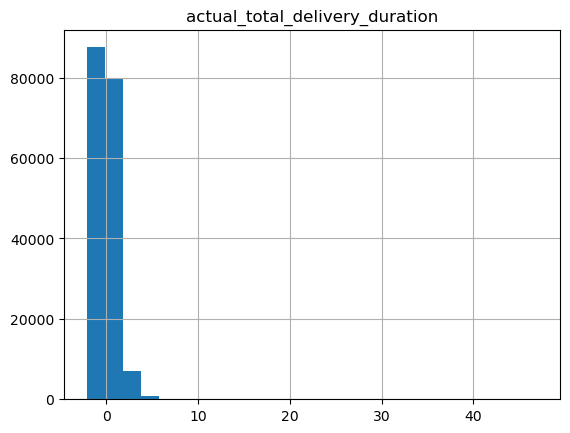

In [28]:
## What is the distribution of the actual_total_delivery_time values around the mean?
x = train_df[['actual_total_delivery_duration']].apply(stats.zscore)
x.hist(column='actual_total_delivery_duration',bins=25)

In [181]:
## dimensionality reduction functions with variance inflaction

def calcVIF(feature_frame:pd.DataFrame,target_feature:str):
    try:
        feature_frame = add_constant(feature_frame)
        feature_list = feature_frame.drop(columns=[target_feature]).columns.to_list()
        vif_frame = pd.DataFrame()
        vif_frame['feature'] = feature_list
        vif_frame['VIF'] = [variance_inflation_factor(feature_frame[feature_list].values,i) for i in range(len(feature_list))]
    except Exception as ex:
        raise ex
    return vif_frame.sort_values(by=['VIF'],ascending=False).reset_index(drop=True)

def VIF_dim_reduction(feature_frame:pd.DataFrame,target_feature:str,vif_limit:int):
    vif_table = calcVIF(feature_frame=feature_frame,target_feature=target_feature)
    try:
        ## drop nan columns from feature set, nan VIF values from base VIF table
        vif_table['VIF'].replace(to_replace=[np.inf,-np.inf],value=np.nan,inplace=True)
        nan_list = vif_table[vif_table['VIF'].isnull()]['feature'].to_list()
        feature_frame = feature_frame.drop(columns=nan_list)
        vif_table = vif_table.set_index(vif_table.feature)
        vif_table = vif_table.drop(labels=nan_list).reset_index(drop=True)
        ## start
        multicollinearity = True if vif_table['VIF'].values.tolist()[1] > vif_limit else False
        while multicollinearity:
            lead_vif_feature = vif_table['feature'].values.tolist()[1]
            feature_frame = feature_frame.drop(columns=lead_vif_feature)
            vif_table = calcVIF(feature_frame=feature_frame,target_feature=target_feature)
            multicollinearity = True if vif_table['VIF'].values.tolist()[1] > vif_limit else False
    except Exception as ex:
        raise ex
    return feature_frame,vif_table

In [31]:
## feature selection/dimensionality reduction with PCA
##TODO #2 make a class for PCA
##TODO #3 retain row numbers in scaler --DONE

def build_train_test(dataset:pd.DataFrame,target_feature:str,test_size:int):
    try:
        X = dataset.drop(columns=target_feature)
        y = dataset[target_feature]
        x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=42)
        x_train,x_test = pd.DataFrame(x_train),pd.DataFrame(x_test)
    except Exception as ex:
        raise ex
    return x_train,x_test,y_train,y_test

def apply_standard_scaler(dataset):
#applies the standard scaler to a single dataset
    scaler = StandardScaler()
    try:
        if type(dataset) == pd.DataFrame:
            scaler = scaler.fit(dataset.values)
            dataset_scaled = scaler.transform(dataset.values)
            dataset_scaled = pd.DataFrame(dataset_scaled,index=dataset.index,columns=dataset.columns)
        else:
            scaler = scaler.fit(dataset)
            dataset_scaled = scaler.transform(dataset)
            test_stdScale = scaler.transform(dataset)
    except Exception as ex:
        raise ex
    return dataset_scaled,scaler

def transform_rmse_to_seconds(scaler,y_test,y_hat_scaled):
    try:
        y_hat_descaled = scaler.inverse_transform(y_hat_scaled.reshape(-1,1))
        rmse_descaled = mean_squared_error(y_pred=y_test,y_true=y_hat_descaled[:,0],squared=False)
    except Exception as ex:
        raise ex
    return y_hat_descaled,rmse_descaled

In [185]:
def PCAcalc_expl_var(x_train,target_expl_variance:int):
## returns the number of components required to explain the target_expl_variance
# and a feature to component ratio to support automation of further dimensionality reduction
    pca = PCA()
    x_train_scaled = apply_standard_scaler(x_train)[0]
    try:
        pca = pca.fit(x_train_scaled)
        components = np.cumsum(pca.explained_variance_ratio_)
        components = [i for i in components if i <= target_expl_variance]
        feature_to_component_ratio = len(components)/x_train.shape[1]
    except Exception as ex:
        raise ex
    return components,feature_to_component_ratio

def PCAcalc_dim_reduction(x_train,x_test,desired_components:int):
## you know, dimensionality reduction
    pca = PCA(n_components=desired_components)
    x_train_scaled,x_test_scaled = apply_standard_scaler(x_train)[0],apply_standard_scaler(x_test)[0]
    try:
        pca = pca.fit(x_train_scaled)
        x_train_pca,x_test_pca = pca.transform(x_train_scaled),pca.transform(x_test_scaled)
    except Exception as ex:
        raise ex
    return x_train_pca,x_test_pca

#### Dimensionality reduction with VIF

In [ ]:
VIF_features = VIF_dim_reduction(feature_frame=train_df,target_feature='actual_total_delivery_duration',vif_limit=20)[1]
VIF_featureset = VIF_features.drop(VIF_features[VIF_features.feature == 'const'].index)
VIF_featureset = VIF_featureset['feature'].to_list()
VIF_featureset = VIF_featureset + ['actual_total_delivery_duration']
VIF_train_df = train_df[VIF_featureset]

In [183]:
vif_df_train_test = build_train_test(dataset=VIF_train_df,target_feature='actual_total_delivery_duration',test_size=0.2)

We need 14 features (out of 24 available) to explain 90 percent of the variance after VIF dimensionality reduction


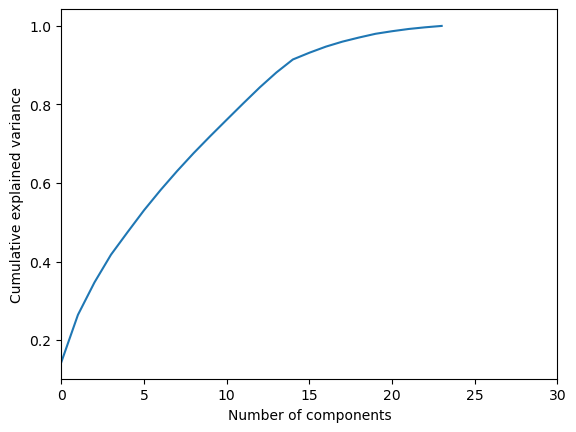

In [187]:
## how many features are needed to explain 90% of the variance?
print("We need " + str(len(PCAcalc_expl_var(x_train=vif_df_train_test[0],target_expl_variance=0.9)[0])) + " features (out of " + str(vif_df_train_test[0].shape[1]) + " available) to explain 90 percent of the variance after VIF dimensionality reduction")

vif_x_train_scaled = apply_standard_scaler(vif_df_train_test[0])[0]
pca = PCA().fit(vif_x_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,30,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

#### Dimensionality reduction with PCA

In [191]:
pca_xtrain,pca_xtest,pca_ytrain,pca_ytest = build_train_test(dataset=train_df,target_feature='actual_total_delivery_duration',test_size=0.2)

In [192]:
xtrain_pca,xtest_pca = PCAcalc_dim_reduction(
    x_train=pca_xtrain,
    x_test=pca_xtest,
    desired_components=len(PCAcalc_expl_var(x_train=pca_xtrain,target_expl_variance=0.9)[0])
)

### Model functions, model selection and first round results

In [14]:
## applicator function for ML methods

def applyMethod_make_regression(x_train,y_train,x_test,y_test,model):
    try:
        model.fit(x_train,y_train)
        ## train error
        y_hat_train = model.predict(x_train)
        train_RMSE = mean_squared_error(y_true=y_train,y_pred=y_hat_train,squared=False)
        train_MAE = mean_absolute_error(y_true=y_train,y_pred=y_hat_train)
        ## test error
        y_hat_test = model.predict(x_test)
        test_RMSE = mean_squared_error(y_true=y_test,y_pred=y_hat_test,squared=False)
        test_MAE = mean_absolute_error(y_true=y_test,y_pred=y_hat_test)
        eval_stats = {
            'train_RMSE:':train_RMSE,
            # gives context to the RMSE; the lower the ratio the better
            'train_RMSE_to_mean_ratio':train_RMSE / (np.mean(y_train)),
            'train_MAE:':train_MAE,
            'test_RMSE:':test_RMSE,
            # gives context to the RMSE; the lower the ratio the better
            'test_RMSE_to_mean_ratio':test_RMSE / (np.mean(y_test)),
            'test_MAE:':test_MAE
        }
        trained_model = model
    except Exception as ex:
        raise ex
    return trained_model,y_hat_test,eval_stats

In [32]:
## TODO: #9 add cross-validation to final score delivery --DONE
def ApplyMethod_autoML(x_train,x_test,y_train,y_test,time_budget=int,metric=str,estimator_list=list,task=str,run_cv=bool,cv_folds=int):
    auto_ml = AutoML()
    kf = KFold(n_splits=cv_folds,random_state=42,shuffle=True)
    cv_scores = []
    class xgbGamma(XGBoostEstimator):
        def __init__(self, task="regression", **config):
            super().__init__(objective='reg:gamma', **config)
    auto_ml.add_learner(learner_name="xgb_gamma",learner_class=xgbGamma)
    try:
        auto_ml.fit(X_train=x_train,y_train=y_train,time_budget=time_budget,metric=metric,estimator_list=estimator_list,task=task,seed=42,verbose=0)
        trained_model = auto_ml
        feature_importances_df = pd.DataFrame({'features':auto_ml.feature_names_in_,'importance':auto_ml.feature_importances_})
        ## cross-validation
        if run_cv == True:
            for train_index,test_index in kf.split(x_train):
                cv_xtrain,cv_xtest = x_train.iloc[train_index],x_train.iloc[test_index]
                cv_ytrain,cv_ytest = y_train.iloc[train_index],y_train.iloc[test_index]
                auto_ml.fit(X_train=cv_xtrain,y_train=cv_ytrain,time_budget=time_budget,metric=metric,estimator_list=[str(trained_model.best_estimator)],task=task,seed=42,verbose=0)
                cv_yhat = auto_ml.predict(cv_xtest)
                if task == 'regression':
                    rmse = mean_squared_error(y_true=cv_ytest,y_pred=cv_yhat,squared=False)
                    cv_scores.append(rmse)
                if task == 'classification':
                    accuracy = accuracy_score(y_true=cv_ytest,y_pred=cv_yhat)
                    cv_scores.append(accuracy)
        if task == 'regression':
        ## test error
            y_hat_test = auto_ml.predict(x_test)
            test_RMSE = mean_squared_error(y_true=y_test,y_pred=y_hat_test,squared=False)
            test_MAE = mean_absolute_error(y_true=y_test,y_pred=y_hat_test)
            ## feature importances
            ## train error
            y_hat_train = auto_ml.predict(x_train)
            train_RMSE = mean_squared_error(y_true=y_train,y_pred=y_hat_train,squared=False)
            train_MAE = mean_absolute_error(y_true=y_train,y_pred=y_hat_train)
            eval_stats = {
                'train_RMSE:':train_RMSE,
                # gives context to the RMSE; the lower the ratio the better
                'train_RMSE_to_std_ratio':train_RMSE / (np.std(y_train)),
                'train_MAE:':train_MAE,
                'test_RMSE:':test_RMSE,
                # gives context to the RMSE; the lower the ratio the better
                'test_RMSE_to_std_ratio':test_RMSE / (np.std(y_test)),
                'test_MAE:':test_MAE
            }
        if task == 'classification':
            y_hat_test = auto_ml.predict(x_test)
            y_hat_test_proba = auto_ml.predict_proba(x_test)
            y_hat_train = auto_ml.predict(x_train)
            y_hat_train_proba = auto_ml.predict_proba(x_train)
            eval_stats = {
                'train_accuracy': accuracy_score(y_true=y_train,y_pred=y_hat_train),
                'train_roc_auc': roc_auc_score(y_true=y_train,y_score=y_hat_train_proba[:,1]),
                'test_accuracy': accuracy_score(y_true=y_test,y_pred=y_hat_test),
                'test_roc_auc': roc_auc_score(y_true=y_test,y_score=y_hat_test_proba[:,1])
            }
    except Exception as ex:
        raise ex
    return trained_model,feature_importances_df.sort_values(by='importance',ascending=False),eval_stats,cv_scores

#### PCA versus VIF dimensionality reduction:

TODO: #10 rewrite dimensionality reduction write-up

PCA:

    {'train_RMSE:': 931.81287,
    'train_RMSE_to_mean_ratio': 0.3266211655207943,
    'train_MAE:': 616.80505,
    'test_RMSE:': 922.12134,
    'test_RMSE_to_mean_ratio': 0.3238223636661371,
    'test_MAE:': 633.7323}

VIF:

    {'train_RMSE:': 844.9008,
    'train_RMSE_to_mean_ratio': 0.29615655663211077,
    'train_MAE:': 591.4,
    'test_RMSE:': 949.3395,
    'test_RMSE_to_mean_ratio': 0.33338058768003304,
    'test_MAE:': 649.18304}

No dimensionality reduction:

    {'train_RMSE:': 902.9004,
    'train_RMSE_to_mean_ratio': 0.31669177544879185,
    'train_MAE:': 590.48975,
    'test_RMSE:': 883.9196,
    'test_RMSE_to_mean_ratio': 0.30977442512176745,
    'test_MAE:': 603.2624}


Between the two dimensionality reduction options, PCA slightly beats out VIF. Given that the goal of dimensionality reduction is to reduce compute requirements (and therefore cost) while retaining as much of the unreduced model's performance as possible, it may be best to use a two-step approach. The first step would secure a list of the top ten or fifteen features from a model trained on the unreduced dataset during the regular retraining process and then run PCA on the remaining features. This lighter dataset would then be used to train a production model.

In [196]:
pca_regressions = ApplyMethod_autoML(
    x_train=xtrain_pca,
    x_test=xtest_pca,
    y_train=pca_ytrain,
    y_test=pca_ytest,
    time_budget=180,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    task='regression',
    run_cv=False,
    cv_folds=5
    )
pca_regressions[2]

{'train_RMSE:': 931.81287,
 'train_RMSE_to_mean_ratio': 0.3266211655207943,
 'train_MAE:': 616.80505,
 'test_RMSE:': 922.12134,
 'test_RMSE_to_mean_ratio': 0.3238223636661371,
 'test_MAE:': 633.7323}

In [189]:
## vif xgbregressor
vif_xgb_model = ApplyMethod_autoML(
    x_train=vif_df_train_test[0],
    x_test=vif_df_train_test[1],
    y_train=vif_df_train_test[2],
    y_test=vif_df_train_test[3],
    time_budget=180,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    task='regression',
    run_cv=False,
    cv_folds=5
    )
vif_xgb_model[2]

{'train_RMSE:': 844.9008,
 'train_RMSE_to_mean_ratio': 0.29615655663211077,
 'train_MAE:': 591.4,
 'test_RMSE:': 949.3395,
 'test_RMSE_to_mean_ratio': 0.33338058768003304,
 'test_MAE:': 649.18304}

In [33]:
base_unscaled_train_test = build_train_test(dataset=train_df,target_feature='actual_total_delivery_duration',test_size=0.2)
xtrain_scaled,xtrain_scaler = apply_standard_scaler(base_unscaled_train_test[0])
xtest_scaled,xtest_scaler = apply_standard_scaler(base_unscaled_train_test[1])
ytrain_scaled,ytest_scaler = apply_standard_scaler(np.array(base_unscaled_train_test[2]).reshape(-1,1))
ytest_scaled,ytest_scaler = apply_standard_scaler(np.array(base_unscaled_train_test[3]).reshape(-1,1))

In [ ]:
scaled_base_model = ApplyMethod_autoML(
    x_train=xtrain_scaled,
    x_test=xtest_scaled,
    y_train=ytrain_scaled,
    y_test=ytest_scaled,
    time_budget=180,
    metric='mse',
    estimator_list=['xgboost','xgb_limitdepth'],
    task='regression',
    run_cv=False,
    cv_folds=5
)
scaled_base_model[2]

In [149]:
yhat = scaled_base_model[0].predict(xtest_scaled)
transform_rmse_to_seconds(scaler=ytest_scaler,y_test=base_unscaled_train_test[3],y_hat_scaled=yhat)[1]

872.52985

In [35]:
auto_xgb_no_reduction = ApplyMethod_autoML(
    x_train=base_unscaled_train_test[0],
    x_test=base_unscaled_train_test[1],
    y_train=base_unscaled_train_test[2],
    y_test=base_unscaled_train_test[3],
    time_budget=180,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    task='regression',
    run_cv=False,
    cv_folds=5
)
auto_xgb_no_reduction[2]

{'train_RMSE:': 803.32196,
 'train_RMSE_to_std_ratio': 0.6914510544691006,
 'train_MAE:': 554.49335,
 'test_RMSE:': 870.6705,
 'test_RMSE_to_std_ratio': 0.7789657915168309,
 'test_MAE:': 597.3902}

In [138]:
print("Cross-validation results (RMSE): ")
print(auto_xgb_no_reduction[3])
print("Mean of cross-validation results (RMSE): " + str(np.mean(auto_xgb_no_reduction[3])))
print("Best estimator: " + auto_xgb_no_reduction[0].best_estimator)
print("Best configuration: ")
print(auto_xgb_no_reduction[0].best_config)

Cross-validation results (RMSE): 
[924.6696, 967.5788, 972.99457, 897.3391, 884.804]
Mean of cross-validation results (RMSE): 929.47723
Best estimator: xgb_limitdepth
Best configuration: 
{'n_estimators': 320, 'max_depth': 8, 'min_child_weight': 1.6246436031409632, 'learning_rate': 0.13924406975323256, 'subsample': 0.6897177882905062, 'colsample_bylevel': 0.9440262969164847, 'colsample_bytree': 1.0, 'reg_alpha': 0.005098546530512515, 'reg_lambda': 102.08934941463467}


In [37]:
auto_xgb_no_reduction[1].sort_values(by='importance',ascending=False).head(15)

,features,importance
16,onshift_to_outstanding,0.092247
20,hour_mean_total_outstanding_orders,0.067612
10,est_time_non-prep,0.038387
21,hour_mean_total_onshift_dashers,0.030156
40,store_est_median_total_prep_time,0.029575
31,hour_busy_outs_avg,0.027338
144,created_day_of_week__0,0.025279
15,busy_to_outstanding,0.022975
22,hour_mean_total_busy_dashers,0.019490
38,store_est_time_prep_per_item_mean,0.018125


In [136]:
# does the first attempt at modeling improve on a baseline, average-derived model?
createBaseline(historical_data=historical_data)

{'baseline_MAE:': 783.5442750429107, 'baseline_RMSE:': 19249.89784985233}

### Results so far

First and foremost, is the work and expense of building and maintaining a model worthwhile when compared to a simple 'baseline' approach that uses averages? The results for that baseline model are as follows:

    {'baseline_MAE:': 783.5442750429107, 'baseline_RMSE:': 19249.89784985233}

I scoured the internet and found two other worked examples that appear to use this dataset:

    Stratascratch: holdout RMSE: 986.6912510458277, holdout_size: 0.2,
    raihanmasud (github): mean 5-fold cv RMSE: 1030.6837, holdout RMSE: 1012, holdout_size: 0.33

Performance statistics for my xgboost model against a holdout sample size of 0.2 are as follows:

    {'train_RMSE:': 800.0005,
    'train_RMSE_to_std_ratio': 0.6904016675988109,
    'train_MAE:': 527.19244,
    'test_RMSE:': 876.9018,
    'test_RMSE_to_std_ratio': 0.7768734571659632,
    'test_MAE:': 597.0269}

    Cross-validation results (RMSE): 
    [924.6696, 967.5788, 972.99457, 897.3391, 884.804]

    Mean of cross-validation results (RMSE): 929.47723

Performance statistics for my xgboost model against a holdout size of 0.33:

    {'train_RMSE:': 873.4991,
    'train_RMSE_to_std_ratio': 0.7611590838185001,
    'train_MAE:': 581.7427,
    'test_RMSE:': 926.9857,
    'test_RMSE_to_std_ratio': 0.7968259664464706,
    'test_MAE:': 605.92535}

Conclusions:
1. The time, effort and expense of building and maintaining a model to predict total delivery time is validated by the comparative performance of the baseline approach.
2. There are two significant differences between my approach to this problem and the two other worked examples I found that I believe explain my superior performance. The first difference is the generic per-store order prep time features (addFeatures_store_prep_stats) and the market+hour aggregation features (addFeatures_relative_abundances). The author of the Stratascratch notebook attempted to predict order prep time and raihanmasud did not bother with prep time at all. Neither user bothered to generate aggregate values based on the most important features for their models. The second difference is my use of autoML to do hyperparameter tuning. Raihanmasud hard-coded hyperparameters for their model and the author of the official Stratascratch notebook did not bother with hyperparameter tuning at all.

Other observations:
1. Giving the model leaky features like the amount of time an order spent in the store (delivery_time - (est_order_creation_time + est_driving_duration)) as well as removing observations with high error produces a cross-validated RMSE scores between 250-350. The best holdout RMSE was around 240. From this one could infer that there is a performance floor.
2. Ratio features and store order preparation time features make up eleven of the top fifteen features and eight of the top ten features when ranked by importance. per the graph below there is also a visible increase in the delivery duration when the onshift-to-outstanding ratio decreases, either from high order volumes or low Dasher counts.
3. The table of category prep time metrics do not appear to have a significant effect on estimation, so those features can be left out of the final pipeline. 
4. Variance and independent population analysis confirmed that most of the markets have different hourly average order volumes, but the second-most important feature to the model so far is 'hour_mean_total_outstanding_orders', a basic average aggregation of order volumes across all markets.
5. Normalizing the dataset with a scaler does not produce a significantly better RMSE against the same holdout/test dataset (scaled RMSE 872.52985, unscaled RMSE 876.9018) despite taking longer to train a model.


<AxesSubplot:xlabel='onshift_to_outstanding', ylabel='actual_total_delivery_duration'>

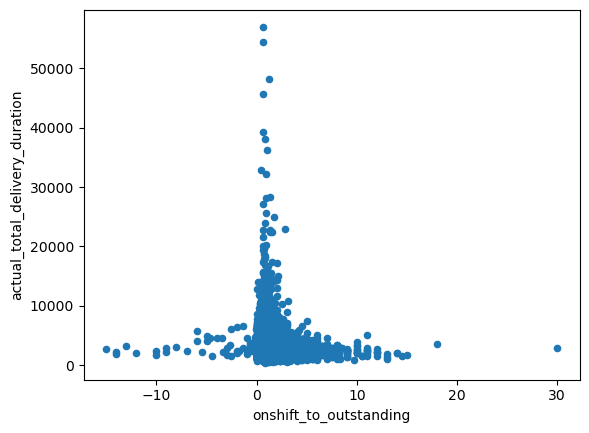

In [154]:
train_df.plot.scatter(x='onshift_to_outstanding',y='actual_total_delivery_duration')

#### What is the relationship between error and acutal_total_delivery_duration?

One could argue that scedasticity does not matter when we make predictions using gradient-boosted-trees - tree-based models are almost invariant to monotonic transformations - but transforms do affect split points. To that end, a test for scedasticity could improve our model if the conditional variance of the data is not constant.

Per the plots below, the variance of the error looks homoscedastic. Trying to actually run White's Lagrange test for heteroscedasticity needs more memory than I can give it.

AxesSubplot(0.125,0.11;0.775x0.77)


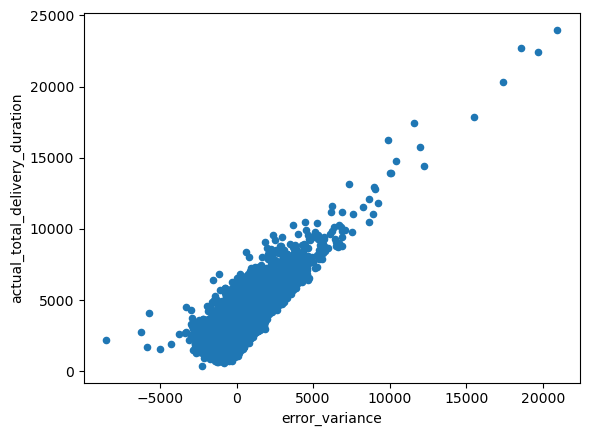

In [45]:
model = auto_xgb_no_reduction[0]
y_hat = model.predict(base_unscaled_train_test[1])
error_train_df = base_unscaled_train_test[1].copy()
error_train_df['yhat'] = y_hat.reshape(-1,1)
error_train_df = error_train_df.join(train_df[['actual_total_delivery_duration']])
error_train_df['error'] = error_train_df['actual_total_delivery_duration'] - error_train_df['yhat']
error_train_df['error_variance'] = error_train_df['error'] - error_train_df['error'].mean()
print(error_train_df.plot.scatter(x='error_variance',y='actual_total_delivery_duration'))
#error_train_df = error_train_df.drop(columns=['yhat','error','error_variance'])

AxesSubplot(0.125,0.11;0.775x0.77)


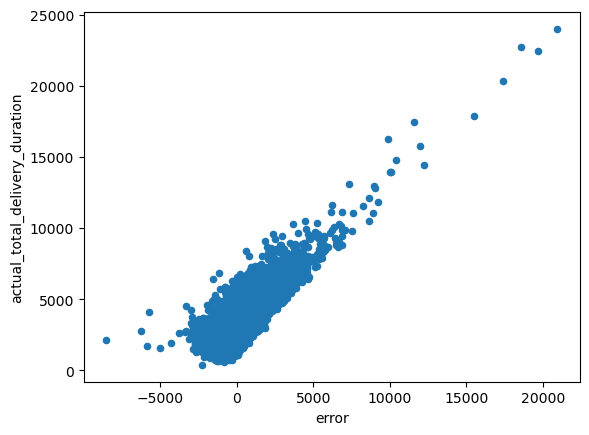

In [47]:
print(error_train_df.plot.scatter(x='error',y='actual_total_delivery_duration'))

In [ ]:
## DO NOT RUN THIS CELL unless you are very invested scedasticity of the data. It is extremely compute and memory intensive.
# More to the point, scedasticity arguably does not matter for gradient-boosted trees
white_test = het_white(resid=error_train_df['error'].values,exog=base_unscaled_train_test[1].values)
white_labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(white_labels,white_test)))

#### Building a model to classify outliers

Given that there is a linear relationship between actual total delivery duration and the absolute error for each observation/order, one could argue that there are features unavailable to us in this dataset that are confounding the features we can use.

How might we go about removing outlier delivery durations while still providing an estimated delivery duration to the customer?

Let's assume that from a customer's perspective, the importance of the accuracy of the delivery decreases with the estimated total delivery duration. At a certain point it might be more viable to inform a customer in-app that their order will be delivered in at least 90 minutes (or that the service is "finding a Dasher..."), rather than providing an actual estimate.

If it is possible to build a model to classify an order as an outlier and then use that model as a filter to decide which orders receive genuine estimates, the delivery duration estimator could then only be trained on data we know will produce higher-quality results. Testing the potential impact of the model is simple; when actual delivery durations over two hours (7200 seconds) are removed from the training set, an AutoML regression model returns the following results:

    {'train_RMSE:': 779.9482,
    'train_RMSE_to_mean_ratio': 0.2767521554477982,
    'train_MAE:': 589.2149,
    'test_RMSE:': 790.5616,
    'test_RMSE_to_mean_ratio': 0.28073476932456126,
    'test_MAE:': 593.6754}

Note that the RMSE-to-mean ratio is significantly less than the same score (0.3108089066798813, a 9.68% improvement) for a model trained on an un-filtered dataset. Even though the mean actual delivery time is lower in the filtered dataset and less data is available for training (4815 dropped rows, 2.737% of the dataset), the model is able to deliver more accurate predictions. This makes the outlier identification model worth building.

In [158]:
dataset = train_df.copy()
dataset['over_one_half_hours'] = dataset['actual_total_delivery_duration'].apply(lambda x: 1 if x >= 5400 else 0)
dataset_train_test = build_train_test(dataset=dataset.drop(columns='actual_total_delivery_duration'),target_feature='over_one_half_hours',test_size=0.2)

In [159]:
label_outlier_model = ApplyMethod_autoML(
    x_train=dataset_train_test[0],
    x_test=dataset_train_test[1],
    y_train=dataset_train_test[2],
    y_test=dataset_train_test[3],
    time_budget=400,
    task='classification',
    metric='accuracy',
    estimator_list=['lgbm','rf','xgboost','extra_tree'],
    run_cv=False,
    cv_folds=5
)
label_outlier_model[2]

{'train_accuracy': 0.9732280651614748,
 'train_roc_auc': 0.8328475548196733,
 'test_accuracy': 0.9734788945728902,
 'test_roc_auc': 0.8289915436603982}

In [160]:
y_pred = label_outlier_model[0].predict(dataset.drop(columns='over_one_half_hours'))
dataset['y_pred'] = y_pred.reshape(-1,1)
trimmed_dataset_train_test = build_train_test(
    dataset=dataset[dataset['y_pred'] == 0].drop(columns=['y_pred','over_one_half_hours']),
    target_feature='actual_total_delivery_duration',
    test_size=0.2
)

In [161]:
trimmed_deliv_pred_model = ApplyMethod_autoML(
    x_train=trimmed_dataset_train_test[0],
    x_test=trimmed_dataset_train_test[1],
    y_train=trimmed_dataset_train_test[2],
    y_test=trimmed_dataset_train_test[3],
    time_budget=180,
    task='regression',
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    run_cv=True,
    cv_folds=5
)
trimmed_deliv_pred_model[2]

{'train_RMSE:': 908.68567,
 'train_RMSE_to_std_ratio': 0.8079694029042364,
 'train_MAE:': 610.612,
 'test_RMSE:': 984.8202,
 'test_RMSE_to_std_ratio': 0.8336647264616844,
 'test_MAE:': 620.38617}

In [163]:
print(trimmed_deliv_pred_model[3])
print(np.mean(trimmed_deliv_pred_model[3]))

[933.0038, 900.2373, 920.4185, 908.0828, 930.56494]
918.46155


In [164]:
trimmed_deliv_pred_model[1].sort_values(by='importance',ascending=False).head(10)

,features,importance
20,hour_mean_total_outstanding_orders,0.188971
10,est_time_non-prep,0.094086
16,onshift_to_outstanding,0.088631
31,hour_busy_outs_avg,0.065510
45,store_est_median_total_prep_time,0.061216
21,hour_mean_total_onshift_dashers,0.041741
118,market_id__1.0,0.033198
9,estimated_store_to_consumer_driving_duration,0.032262
24,market_hour_onshift_to_outstanding_abd,0.031270
15,busy_to_outstanding,0.023833


#### Classification + prediction model results

A model trained on the same featureset (sans 'actual_total_delivery_duration' to prevent leakage) but instead asked to label orders with a total delivery duration of 90 minutes or more - rather than predicting the total delivery duration in seconds - produces the following accuracy scores:

    {'train_accuracy': 0.9732280651614748,
    'train_roc_auc': 0.8328475548196733,
    'test_accuracy': 0.9734788945728902,
    'test_roc_auc': 0.8289915436603982}

Note that the above accuracy scores are for the entire dataset - the classifier model only identified 1235 'outliers' when the dataset actually contained 4815 records with a total delivery duration of 90 minutes or more. Of those 1235 observations/orders, 1101 (89.15%) were correctly labeled and 134 (10.85%) were incorrectly labeled. A success rate of 22.89% may not seem very good prima-facie, but we must contextualize it against the business value of a highly-varied delivery time estimation. Unfortunately that is context we do not have, but we can look at the RMSE of that sub-population to get a sense of the risk of being exposed to a high-error estimation:

    RMSE: 2830.3252
    actual_total_delivery_duration_std: 1669.198608
    RMSE_to_std_ratio: 1.6956191950047

When we use the single model to predict delivery times, the resulting RMSE is more than three times that of the cross-validated RMSE for that same model. That subset of customers would be exposed to wildly innaccurate delivery time estimates if their orders were passed through the single model, but instead they receive a general estimate that can be updated as more information becomes available.

Dropping the orders predicted to take at least 90 minutes and then training a total delivery duration model with that trimmed dataset produces the following metrics:

    {'train_RMSE:': 908.68567,
    'train_RMSE_to_std_ratio': 0.8079694029042364,
    'train_MAE:': 610.612,
    'test_RMSE:': 984.8202,
    'test_RMSE_to_std_ratio': 0.8336647264616844,
    'test_MAE:': 620.38617}

    Cross-validation results (RMSE): 
    [933.0038, 900.2373, 920.4185, 908.0828, 930.56494]

    Mean of cross-validation results (RMSE): 918.46155
    
Was the two-step approach successful? How do we judge success? 

RMSE is sensitive to outliers so we cannot make a direct comparison between those values because we have removed outliers. A better judge of performance in this situation where we are comparing two models with different test and training sets is the RMSE-to-standard-deviation ratio, which contextualizes the error rate against the standard deviation of y-true. The lower the value the better; a value over 1 can be considered a 'red-flag' in that the model's error produces more variance than the real data. If the RMSE-to-std ratio is significantly better for the top-coded approach, we could argue that the final model is doing a better job of accounting for the remaining outliers than the single model approach.

The above performance statistics are undeniably worse than those of the single-model approach.

This should not happen given the clear relationship between the value we are trying to predict and estimation error. It must be said that these numbers are worse than previous iterations of this top-coded two-step approach; a prior iteration had a cross-validation RMSE of 897.623 which was slightly better than the same value for the single-model approach. What changed is the features; the features produced by the function 'addFeatures_relative_abundances()' have clearly changed the top-coded approach for the worse. 

One other note: I did apply log and standard normalization to the dataset in an attempt to mitigate the effect of the outliers, but normalization/standardization had little to no effect on performance.

### What about a model that predicts order prep/in-store time?

1. Is the amount of time an order spends in the restaurant (prep time) an important feature? 
2. Would the accuracy of a total delivery time model be improved by having an estimation of order preparation time for each order?
3. Assuming the answers to the first two questions are true, is it worth keeping the store and category prepartion stats 'tables' I made during the feature engineering step?

In [176]:
## first and foremost, is this model worth building? Is in-store time an important feature?
hypoth_df = train_df.copy()
hypoth_df['est_order_total_prep_time'] = hypoth_df['actual_total_delivery_duration'] - hypoth_df['est_time_non-prep']


In [178]:
# hypoth_feature_df = VIF_dim_reduction(feature_frame=hypoth_df,target_feature='actual_total_delivery_duration',vif_limit=20)[0]
hypoth_xtrain,hypoth_xtest,hypoth_ytrain,hypoth_ytest = build_train_test(dataset=hypoth_df,target_feature='actual_total_delivery_duration',test_size=0.2)
hypoth_feature_importances = ApplyMethod_autoML(
    x_train=hypoth_xtrain,
    x_test=hypoth_xtest,
    y_train=hypoth_ytrain,
    y_test=hypoth_ytest,
    time_budget=60,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost'],
    task='regression',
    run_cv=False,
    cv_folds=5
)
hypoth_feature_importances[2]

{'train_RMSE:': 312.8918,
 'train_RMSE_to_std_ratio': 0.270026123916784,
 'train_MAE:': 27.744295,
 'test_RMSE:': 251.92336,
 'test_RMSE_to_std_ratio': 0.2231864150144342,
 'test_MAE:': 26.811071}

In [179]:
hypoth_feature_importances[1].sort_values(by='importance',ascending=False).head(15)

,features,importance
156,est_order_total_prep_time,0.348091
10,est_time_non-prep,0.209039
21,hour_mean_total_onshift_dashers,0.115692
16,onshift_to_outstanding,0.113821
9,estimated_store_to_consumer_driving_duration,0.084944
37,store_est_time_prep_per_item_median,0.031350
38,store_est_time_prep_per_item_mean,0.030787
39,store_est_time_prep_per_item_std,0.026761
36,store_est_time_prep_per_item_max,0.016004
8,estimated_order_place_duration,0.004808


Per the performance scores and feature importance table above, providing a delivery time estimation model with an order prep time estimation greatly improves the quality of estimations. Since the feature est_order_total_prep_time is leaky (it depends on the value we are trying to predict), we will need to estimate it instead.

In [180]:
prep_est_train_test = build_train_test(dataset=hypoth_df.drop(columns='actual_total_delivery_duration'),target_feature='est_order_total_prep_time',test_size=0.2)
prep_est_model = ApplyMethod_autoML(
    x_train=prep_est_train_test[0],
    x_test=prep_est_train_test[1],
    y_train=prep_est_train_test[2],
    y_test=prep_est_train_test[3],
    time_budget=180,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    task='regression',
    cv_folds=5,
    run_cv=False
)
prep_est_model[2]

{'train_RMSE:': 881.14136,
 'train_RMSE_to_std_ratio': 0.7838877053612336,
 'train_MAE:': 588.1481,
 'test_RMSE:': 878.3562,
 'test_RMSE_to_std_ratio': 0.8048464649644018,
 'test_MAE:': 599.6253}

In [181]:
prep_est_model[1].sort_values(by='importance',ascending=False).head(15)

,features,importance
16,onshift_to_outstanding,0.111933
21,hour_mean_total_onshift_dashers,0.094169
22,hour_mean_total_busy_dashers,0.063953
20,hour_mean_total_outstanding_orders,0.060035
45,store_est_median_total_prep_time,0.037431
15,busy_to_outstanding,0.035190
31,hour_busy_outs_avg,0.024215
149,created_day_of_week__0,0.022797
38,store_est_time_prep_per_item_mean,0.019698
118,market_id__1.0,0.016121


In [191]:
yhat_train,yhat_test = prep_est_model[0].predict(prep_est_train_test[0]),prep_est_model[0].predict(prep_est_train_test[1])
composite_train,composite_test = prep_est_train_test[0],prep_est_train_test[1]
composite_train['pred_order_prep_time'],composite_test['pred_order_prep_time'] = yhat_train.reshape(-1,1),yhat_test.reshape(-1,1)
#composite_train['composite_deliv_time'],composite_test['composite_deliv_time'] = composite_train['pred_order_prep_time'] + composite_train['est_time_non-prep'],composite_test['pred_order_prep_time'] + composite_test['est_time_non-prep']
composite_train,composite_test = composite_train.join(hypoth_df[['actual_total_delivery_duration']]),composite_test.join(hypoth_df[['actual_total_delivery_duration']])

<AxesSubplot:xlabel='est_order_total_prep_time', ylabel='error'>

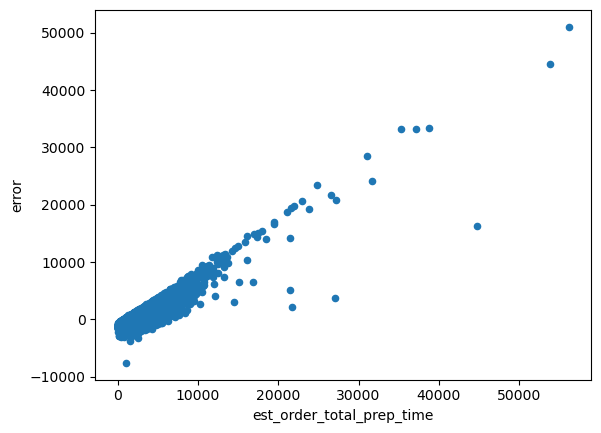

In [183]:
dgr = composite_train.join(hypoth_df[['est_order_total_prep_time']])
dgr['abs_error'] = abs(dgr['est_order_total_prep_time'] - dgr['pred_order_prep_time'])
dgr['error'] = dgr['est_order_total_prep_time'] - dgr['pred_order_prep_time']
dgr.plot.scatter(x='est_order_total_prep_time',y='error')

In [195]:
composite_deliv_model = ApplyMethod_autoML(
    x_train=composite_train.drop(columns=['actual_total_delivery_duration','composite_deliv_time']),
    x_test=composite_test.drop(columns=['actual_total_delivery_duration','composite_deliv_time']),
    y_train=composite_train['actual_total_delivery_duration'],
    y_test=composite_test['actual_total_delivery_duration'],
    time_budget=180,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    task='regression',
    cv_folds=5,
    run_cv=True
)
composite_deliv_model[2]

{'train_RMSE:': 793.01575,
 'train_RMSE_to_std_ratio': 0.6843738250531922,
 'train_MAE:': 559.7056,
 'test_RMSE:': 907.7776,
 'test_RMSE_to_std_ratio': 0.8042272435967454,
 'test_MAE:': 600.7541}

w/ composite_deliv_time:
{'train_RMSE:': 815.1652,
 'train_RMSE_to_std_ratio': 0.7034888565661281,
 'train_MAE:': 570.45123,
 'test_RMSE:': 912.44415,
 'test_RMSE_to_std_ratio': 0.808361492679291,
 'test_MAE:': 600.00836}

cv RMSE scores: [867.7579, 910.20544, 906.0279, 855.9836, 840.6531]
Mean RMSE from cv: 876.1256
cv RMSE to y-true std: 0.7761858125345661

 w/o composite_deliv_time:
{'train_RMSE:': 793.01575,
 'train_RMSE_to_std_ratio': 0.6843738250531922,
 'train_MAE:': 559.7056,
 'test_RMSE:': 907.7776,
 'test_RMSE_to_std_ratio': 0.8042272435967454,
 'test_MAE:': 600.7541}

[860.98395, 901.5238, 898.82605, 853.83453, 833.52484]
869.73865
0.7705274115903241

In [196]:
print(composite_deliv_model[3])
print(np.mean(composite_deliv_model[3]))
print(np.mean(composite_deliv_model[3])/np.std(composite_test['actual_total_delivery_duration']))

[860.98395, 901.5238, 898.82605, 853.83453, 833.52484]
869.73865
0.7705274115903241


In [197]:
composite_deliv_model[1].sort_values(by='importance',ascending=False).head(15)

,features,importance
156,pred_order_prep_time,0.139058
147,created_hour_of_day__22,0.048176
10,est_time_non-prep,0.036919
6,total_busy_dashers,0.032640
8,estimated_order_place_duration,0.031526
90,clean_store_primary_category__mediterranean,0.030337
5,total_onshift_dashers,0.023403
16,onshift_to_outstanding,0.021803
84,clean_store_primary_category__japanese,0.017603
123,market_id__6.0,0.016424


Despite adding a new and promising feature, the inability of the first model to accurately estimate the amount of time an order spends in the store produces a somewhat disappointing outcome. The cross-validated RMSE is only 869.73865.